# Fixed GA Baseline vs Adaptive MPC Comparison

This notebook compares:
- **GA Fixed Strategy**
- **MPC Adaptive Strategy**: Daily re-optimization based on observed weather conditions

**Key insight**: The GA strategy was determined without knowledge of the actual weather that will occur. This represents a realistic scenario where farmers must commit to a strategy before the growing season. In contrast, MPC adapts in real-time to actual weather conditions.

The question is: **How much does adaptability help when weather is uncertain?**

In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
from scipy import stats

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_member import Member
from core.ga.ga_params import GeneticAlgorithmParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.plotting.plotting_params import PlottingParams
from core.plotting.plotting_colors import PlottingColors

# Apply plotting style (LaTeX + color-blind friendly)
plotting_params = PlottingParams()
plotting_colors = PlottingColors()
plotting_colors.apply_as_default()

## 1. Define Fixed GA Baseline Strategy

This is the farmer's best practice strategy from `ga_single_simulation.ipynb`, optimized for drought conditions (0.5x precipitation). The strategy does NOT adapt to actual weather.

In [2]:
# Fixed GA baseline strategy (farmer's best practice)
# This strategy was determined without knowledge of actual weather
FIXED_IRRIGATION_FREQUENCY = 1236.7362895452
FIXED_IRRIGATION_AMOUNT    = 4.9896961931
FIXED_FERTILIZER_FREQUENCY = 803.2474625247
FIXED_FERTILIZER_AMOUNT    = 76.7713014035

print("Fixed GA Baseline Strategy:")
print(f"  Irrigation: Every {FIXED_IRRIGATION_FREQUENCY} hours ({FIXED_IRRIGATION_FREQUENCY/24:.0f} days) at {FIXED_IRRIGATION_AMOUNT} inch")
print(f"  Fertilizer: Every {FIXED_FERTILIZER_FREQUENCY} hours ({FIXED_FERTILIZER_FREQUENCY/24:.0f} days) at {FIXED_FERTILIZER_AMOUNT} lbs")
print("\nThis strategy yields ~$999 on the drought scenario it was optimized for.")

Fixed GA Baseline Strategy:
  Irrigation: Every 1236.7362895452 hours (52 days) at 4.9896961931 inch
  Fertilizer: Every 803.2474625247 hours (33 days) at 76.7713014035 lbs

This strategy yields ~$999 on the drought scenario it was optimized for.


## 2. Load Weather Scenarios and MPC Results

In [3]:
# Load weather scenarios
with open('weather_scenario_results/weather_scenarios.pkl', 'rb') as f:
    weather_data = pickle.load(f)

with open('weather_scenario_results/scenario_configs.pkl', 'rb') as f:
    scenarios = pickle.load(f)

# Load MPC results (already computed)
with open('weather_scenario_results/mpc_scenario_results.pkl', 'rb') as f:
    mpc_results = pickle.load(f)

with open('weather_scenario_results/mpc_trajectories.pkl', 'rb') as f:
    mpc_trajectories = pickle.load(f)

print(f"Loaded {len(weather_data)} weather scenarios")
print(f"Loaded MPC results for {len(mpc_results)} scenarios")

Loaded 21 weather scenarios
Loaded MPC results for 21 scenarios


## 3. Set Up Model Parameters

In [4]:
# Model parameters (same as ga_single_simulation.ipynb)
model_params = ModelParams(
    dt               = 0.1,   # hours/step
    simulation_hours = 2900,  # hours
    closed_form      = True,
    verbose          = False
)

carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,   # m
    kA = 0.65,  # m2
    kN = 20,    # number of leaves
    kc = 1000,  # number of spikelets
    kP = 0.25   # kg
)

growth_rates = ModelGrowthRates(
    ah = 0.01,    # 1/hr
    aA = 0.0105,  # 1/hr
    aN = 0.011,   # 1/hr
    ac = 0.01,    # 1/hr
    aP = 0.005    # 1/hr
)

sensitivities = ModelSensitivities(
    sigma_W = 30,   # hrs
    sigma_F = 300,  # hrs
    sigma_T = 30,   # hrs
    sigma_R = 30    # hrs
)

initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours,
    A0=carrying_capacities.kA/model_params.simulation_hours,
    N0=carrying_capacities.kN/model_params.simulation_hours,
    c0=carrying_capacities.kc/model_params.simulation_hours,
    P0=carrying_capacities.kP/model_params.simulation_hours
)

default_typical_disturbances = ModelTypicalDisturbances()
typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

ga_params = GeneticAlgorithmParams()

# Economic weights
weight_fruit_biomass = ga_params.weight_fruit_biomass
weight_height = ga_params.weight_height
weight_leaf_area = ga_params.weight_leaf_area
weight_irrigation = ga_params.weight_irrigation
weight_fertilizer = ga_params.weight_fertilizer

print("Model parameters configured.")

Model parameters configured.


## 4. Run Fixed GA Strategy on All Weather Scenarios

Apply the same fixed strategy to all 21 scenarios - the strategy does NOT adapt to weather conditions.

In [5]:
# Run fixed GA strategy on each weather scenario
fixed_ga_results = {}
scenario_configs = {s.name: s for s in scenarios}

scenario_names = list(weather_data.keys())
total_scenarios = len(scenario_names)

print(f"Running fixed GA strategy on {total_scenarios} scenarios...")
print("(The same strategy is applied to every scenario - no adaptation)\n")

for i, scenario_name in enumerate(scenario_names):
    print(f"[{i+1}/{total_scenarios}] Evaluating {scenario_name}...", end=" ")
    
    weather_df = weather_data[scenario_name]
    
    # Create disturbances for this scenario
    scenario_disturbances = ModelDisturbances(
        precipitation = weather_df['Hourly Precipitation (in)'].to_numpy(),
        radiation     = weather_df['Hourly Radiation (W/m2)'].to_numpy(),
        temperature   = weather_df['Temperature (C)'].to_numpy()
    )
    
    # Create member with FIXED strategy (same for all scenarios)
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = scenario_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = model_params,
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values = np.array([
            FIXED_IRRIGATION_FREQUENCY,
            FIXED_IRRIGATION_AMOUNT,
            FIXED_FERTILIZER_FREQUENCY,
            FIXED_FERTILIZER_AMOUNT
        ])
    )
    
    # Get cost (negative revenue)
    cost = member.get_cost()
    revenue = -cost
    
    # Calculate total inputs
    simulation_hours = len(scenario_disturbances.precipitation)
    total_irrigation = np.sum([FIXED_IRRIGATION_AMOUNT for t in range(0, simulation_hours, int(FIXED_IRRIGATION_FREQUENCY))])
    total_fertilizer = np.sum([FIXED_FERTILIZER_AMOUNT for t in range(0, simulation_hours, int(FIXED_FERTILIZER_FREQUENCY))])
    
    # Read output for final states
    output = pd.read_csv(os.path.join(project_root, 'examples/ga/output_get_cost.csv'))
    
    fixed_ga_results[scenario_name] = {
        'revenue': revenue,
        'fruit_biomass': output['P'].iloc[-1],
        'height': output['h'].iloc[-1],
        'leaf_area': output['A'].iloc[-1],
        'total_irrigation': total_irrigation,
        'total_fertilizer': total_fertilizer,
        'precip_total': weather_df['Hourly Precipitation (in)'].sum(),
        'temp_mean': weather_df['Temperature (C)'].mean(),
        'extremity': scenario_configs[scenario_name].extremity_index() if scenario_name in scenario_configs else 0.0
    }
    
    print(f"Revenue=${revenue:7.2f}")

print("\nFixed GA strategy evaluation complete!")

Running fixed GA strategy on 21 scenarios...
(The same strategy is applied to every scenario - no adaptation)

[1/21] Evaluating normal_1... Revenue=$ 783.60
[2/21] Evaluating normal_2... Revenue=$ 819.09
[3/21] Evaluating normal_3... Revenue=$ 739.19
[4/21] Evaluating normal_4... Revenue=$ 842.28
[5/21] Evaluating normal_5... Revenue=$ 695.56
[6/21] Evaluating moderate_dry... Revenue=$ 912.54
[7/21] Evaluating moderate_wet... Revenue=$ 629.12
[8/21] Evaluating moderate_warm... Revenue=$ 791.36
[9/21] Evaluating moderate_cool... Revenue=$ 651.68
[10/21] Evaluating moderate_variable... Revenue=$ 783.62
[11/21] Evaluating mild_drought... Revenue=$ 997.15
[12/21] Evaluating summer_drought... Revenue=$ 943.50
[13/21] Evaluating early_drought... Revenue=$ 993.31
[14/21] Evaluating late_drought... Revenue=$ 990.51
[15/21] Evaluating wet_year... Revenue=$ 550.86
[16/21] Evaluating cool_wet... Revenue=$ 549.83
[17/21] Evaluating heat_stress... Revenue=$ 854.67
[18/21] Evaluating multiple_heatw

## 5. Build Comparison DataFrame

In [6]:
# Build comparison DataFrame
comparison_data = []

for scenario_name in fixed_ga_results.keys():
    ga_rev = fixed_ga_results[scenario_name]['revenue']
    mpc_rev = mpc_results[scenario_name]['revenue'] if scenario_name in mpc_results else np.nan
    extremity = fixed_ga_results[scenario_name]['extremity']
    
    # Calculate MPC advantage
    mpc_advantage = mpc_rev - ga_rev if not np.isnan(mpc_rev) else np.nan
    mpc_advantage_pct = (mpc_advantage / abs(ga_rev) * 100) if ga_rev != 0 else np.nan
    
    comparison_data.append({
        'scenario': scenario_name,
        'fixed_ga_revenue': ga_rev,
        'mpc_revenue': mpc_rev,
        'mpc_advantage': mpc_advantage,
        'mpc_advantage_pct': mpc_advantage_pct,
        'extremity': extremity,
        'ga_fruit': fixed_ga_results[scenario_name]['fruit_biomass'],
        'mpc_fruit': mpc_results[scenario_name]['fruit_biomass'] if scenario_name in mpc_results else np.nan,
        'ga_irrigation': fixed_ga_results[scenario_name]['total_irrigation'],
        'mpc_irrigation': mpc_results[scenario_name]['total_irrigation'] if scenario_name in mpc_results else np.nan,
        'ga_fertilizer': fixed_ga_results[scenario_name]['total_fertilizer'],
        'mpc_fertilizer': mpc_results[scenario_name]['total_fertilizer'] if scenario_name in mpc_results else np.nan,
        'precip_total': fixed_ga_results[scenario_name]['precip_total'],
        'temp_mean': fixed_ga_results[scenario_name]['temp_mean']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('extremity').reset_index(drop=True)

print("Comparison Summary (Fixed GA Strategy vs Adaptive MPC):")
print(comparison_df[['scenario', 'fixed_ga_revenue', 'mpc_revenue', 'mpc_advantage', 'extremity']].to_string())

Comparison Summary (Fixed GA Strategy vs Adaptive MPC):
                scenario  fixed_ga_revenue  mpc_revenue  mpc_advantage  extremity
0               normal_1        783.596676   849.883201      66.286525       0.00
1      moderate_variable        783.618963   847.433203      63.814239       0.00
2               baseline        783.977440   848.396220      64.418780       0.00
3               normal_2        819.090090   877.399361      58.309271       0.20
4               normal_3        739.194492   815.459778      76.265285       0.20
5               normal_4        842.280441   885.513493      43.233051       0.40
6               normal_5        695.556089   774.338754      78.782665       0.40
7          moderate_cool        651.683773   735.628443      83.944670       0.60
8           moderate_wet        629.116454   715.772739      86.656286       0.70
9          moderate_warm        791.359421   845.881483      54.522062       0.70
10          moderate_dry        912.544404

In [7]:
# Summary statistics
valid = comparison_df[comparison_df['mpc_revenue'].notna()]

print("\n" + "=" * 70)
print("SUMMARY STATISTICS: Fixed GA Baseline vs Adaptive MPC")
print("=" * 70)

print(f"\nFixed GA Strategy (Same for All Scenarios):")
print(f"  Mean revenue:  ${valid['fixed_ga_revenue'].mean():8.2f}")
print(f"  Std revenue:   ${valid['fixed_ga_revenue'].std():8.2f}")
print(f"  Min revenue:   ${valid['fixed_ga_revenue'].min():8.2f}")
print(f"  Max revenue:   ${valid['fixed_ga_revenue'].max():8.2f}")

print(f"\nMPC Adaptive Strategy:")
print(f"  Mean revenue:  ${valid['mpc_revenue'].mean():8.2f}")
print(f"  Std revenue:   ${valid['mpc_revenue'].std():8.2f}")
print(f"  Min revenue:   ${valid['mpc_revenue'].min():8.2f}")
print(f"  Max revenue:   ${valid['mpc_revenue'].max():8.2f}")

print(f"\nMPC Advantage Over Fixed GA:")
print(f"  Mean advantage:  ${valid['mpc_advantage'].mean():8.2f}")
print(f"  Max advantage:   ${valid['mpc_advantage'].max():8.2f}")
print(f"  Min advantage:   ${valid['mpc_advantage'].min():8.2f}")
print(f"  % scenarios where MPC wins: {(valid['mpc_advantage'] > 0).mean() * 100:.1f}%")


SUMMARY STATISTICS: Fixed GA Baseline vs Adaptive MPC

Fixed GA Strategy (Same for All Scenarios):
  Mean revenue:  $  796.09
  Std revenue:   $  132.08
  Min revenue:   $  549.83
  Max revenue:   $  997.15

MPC Adaptive Strategy:
  Mean revenue:  $  749.71
  Std revenue:   $  115.35
  Min revenue:   $  444.93
  Max revenue:   $  885.51

MPC Advantage Over Fixed GA:
  Mean advantage:  $  -46.37
  Max advantage:   $   90.94
  Min advantage:   $ -317.14
  % scenarios where MPC wins: 57.1%


## 6. Visualization 1: Revenue Comparison by Scenario

Side-by-side comparison showing how the fixed GA strategy performs vs adaptive MPC across all weather scenarios.

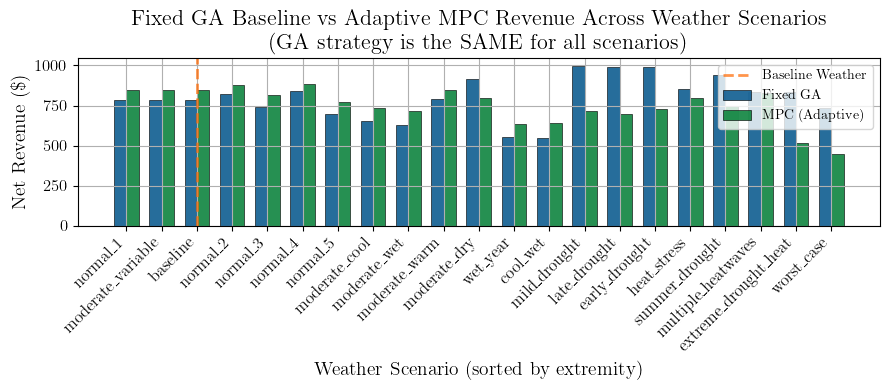

In [16]:
fig, ax = plt.subplots(figsize=(9, 4))

x = np.arange(len(comparison_df))
width = 0.35

# Create bars
bars_ga = ax.bar(x - width/2, comparison_df['fixed_ga_revenue'], width, 
                  label='Fixed GA', color=plotting_colors.strong_blue, 
                  alpha=0.85, edgecolor='black', linewidth=0.5)
bars_mpc = ax.bar(x + width/2, comparison_df['mpc_revenue'], width,
                   label='MPC (Adaptive)', color=plotting_colors.vivid_green, 
                   alpha=0.85, edgecolor='black', linewidth=0.5)

# Highlight baseline scenario
baseline_idx = comparison_df[comparison_df['scenario'] == 'baseline'].index
if len(baseline_idx) > 0:
    ax.axvline(baseline_idx[0], color=plotting_colors.vivid_orange, linestyle='--', 
               linewidth=2, alpha=0.7, label='Baseline Weather')

# Labels
ax.set_xlabel('Weather Scenario (sorted by extremity)')
ax.set_ylabel('Net Revenue (\\$)')
ax.set_title('Fixed GA Baseline vs Adaptive MPC Revenue Across Weather Scenarios\n(GA strategy is the SAME for all scenarios)')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['scenario'], rotation=45, ha='right')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('weather_scenario_results/fixed_ga_vs_mpc_revenue_bars.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Visualization 2: MPC Advantage vs Weather Extremity

This is the key plot showing that MPC's advantage over the fixed strategy grows as weather becomes more extreme.

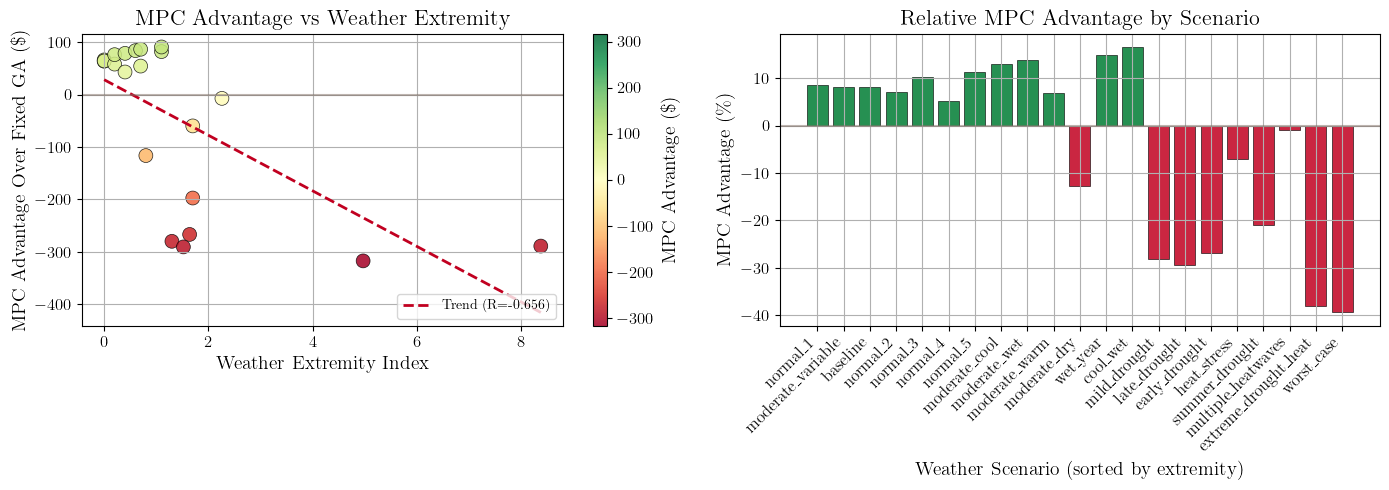


Correlation between extremity and MPC advantage:
  Pearson R = -0.656
  p-value = 0.0012
  Slope = \$-52.98 per unit extremity


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Absolute advantage scatter with trend
ax1 = axes[0]
sc = ax1.scatter(valid['extremity'], valid['mpc_advantage'], 
                 c=valid['mpc_advantage'], cmap='RdYlGn', s=100, 
                 edgecolor='black', linewidth=0.5, alpha=0.85,
                 vmin=-max(abs(valid['mpc_advantage'])), vmax=max(abs(valid['mpc_advantage'])))
plt.colorbar(sc, ax=ax1, label='MPC Advantage (\\$)')

# Add trend line
slope, intercept, r_value, p_value, std_err = stats.linregress(valid['extremity'], valid['mpc_advantage'])
x_trend = np.linspace(valid['extremity'].min(), valid['extremity'].max(), 100)
ax1.plot(x_trend, slope * x_trend + intercept, color=plotting_colors.vivid_red, 
         linestyle='--', linewidth=2, label=f'Trend (R={r_value:.3f})')

ax1.axhline(0, color=plotting_colors.medium_gray, linestyle='-', alpha=0.5)
ax1.set_xlabel('Weather Extremity Index')
ax1.set_ylabel('MPC Advantage Over Fixed GA (\\$)')
ax1.set_title('MPC Advantage vs Weather Extremity')
ax1.legend(loc='lower right')

# Right: Percentage advantage bar chart sorted by extremity
ax2 = axes[1]
bar_colors = [plotting_colors.vivid_green if x > 0 else plotting_colors.vivid_red 
              for x in valid['mpc_advantage_pct']]
ax2.bar(range(len(valid)), valid['mpc_advantage_pct'], color=bar_colors, 
        alpha=0.85, edgecolor='black', linewidth=0.5)
ax2.set_xticks(range(len(valid)))
ax2.set_xticklabels(valid['scenario'], rotation=45, ha='right')
ax2.axhline(0, color=plotting_colors.medium_gray, linestyle='-', alpha=0.5)
ax2.set_xlabel('Weather Scenario (sorted by extremity)')
ax2.set_ylabel('MPC Advantage (\\%)')
ax2.set_title('Relative MPC Advantage by Scenario')

plt.tight_layout()
plt.savefig('weather_scenario_results/fixed_ga_vs_mpc_advantage.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nCorrelation between extremity and MPC advantage:")
print(f"  Pearson R = {r_value:.3f}")
print(f"  p-value = {p_value:.4f}")
print(f"  Slope = \${slope:.2f} per unit extremity")

## 8. Visualization 3: Resource Usage Comparison

The fixed GA strategy applies the same irrigation and fertilizer regardless of weather. MPC adapts its resource usage to actual conditions.

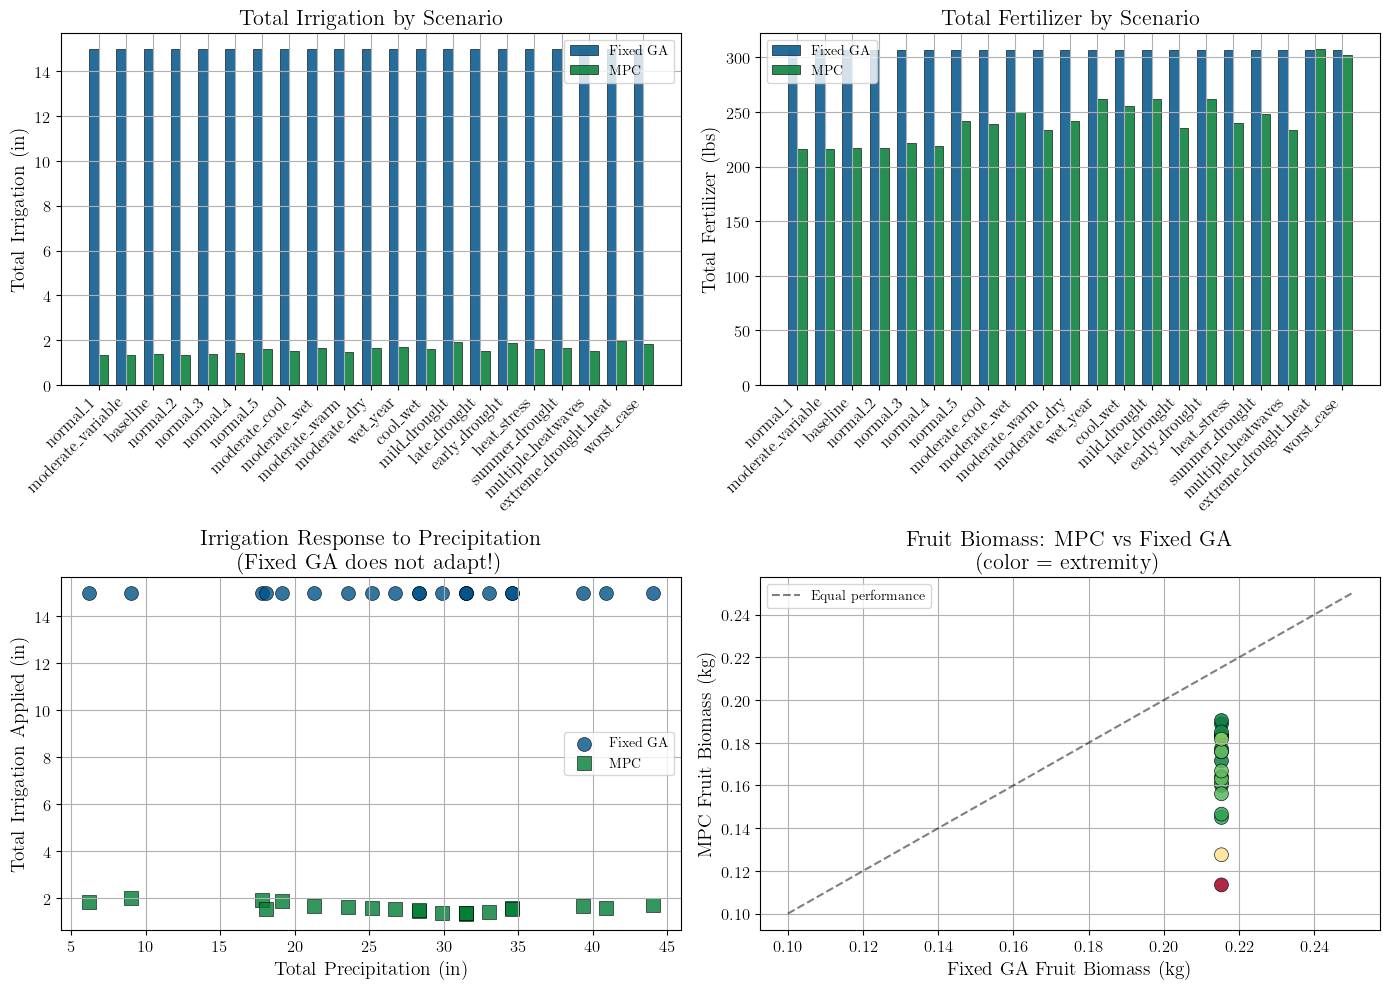


Fixed GA uses same resources for ALL scenarios:
  Irrigation: 15.0 in
  Fertilizer: 307.1 lbs

MPC adapts resources to each scenario:
  Irrigation: 1.3 - 2.0 in
  Fertilizer: 215.6 - 307.1 lbs


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: Irrigation comparison
ax = axes[0, 0]
x = np.arange(len(valid))
width = 0.35
ax.bar(x - width/2, valid['ga_irrigation'], width, label='Fixed GA', 
       color=plotting_colors.strong_blue, alpha=0.85, edgecolor='black', linewidth=0.5)
ax.bar(x + width/2, valid['mpc_irrigation'], width, label='MPC', 
       color=plotting_colors.vivid_green, alpha=0.85, edgecolor='black', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(valid['scenario'], rotation=45, ha='right')
ax.set_ylabel('Total Irrigation (in)')
ax.set_title('Total Irrigation by Scenario')
ax.legend()

# Top right: Fertilizer comparison
ax = axes[0, 1]
ax.bar(x - width/2, valid['ga_fertilizer'], width, label='Fixed GA', 
       color=plotting_colors.strong_blue, alpha=0.85, edgecolor='black', linewidth=0.5)
ax.bar(x + width/2, valid['mpc_fertilizer'], width, label='MPC', 
       color=plotting_colors.vivid_green, alpha=0.85, edgecolor='black', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(valid['scenario'], rotation=45, ha='right')
ax.set_ylabel('Total Fertilizer (lbs)')
ax.set_title('Total Fertilizer by Scenario')
ax.legend()

# Bottom left: Irrigation vs precipitation
ax = axes[1, 0]
ax.scatter(valid['precip_total'], valid['ga_irrigation'], 
           label='Fixed GA', color=plotting_colors.strong_blue, s=100, 
           alpha=0.8, marker='o', edgecolor='black', linewidth=0.5)
ax.scatter(valid['precip_total'], valid['mpc_irrigation'],
           label='MPC', color=plotting_colors.vivid_green, s=100, 
           alpha=0.8, marker='s', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Total Precipitation (in)')
ax.set_ylabel('Total Irrigation Applied (in)')
ax.set_title('Irrigation Response to Precipitation\n(Fixed GA does not adapt!)')
ax.legend()

# Bottom right: Fruit biomass comparison
ax = axes[1, 1]
ax.scatter(valid['ga_fruit'], valid['mpc_fruit'], 
           c=valid['extremity'], cmap='RdYlGn_r', s=100, 
           edgecolor='black', linewidth=0.5, alpha=0.85)
ax.plot([0.1, 0.25], [0.1, 0.25], 'k--', alpha=0.5, label='Equal performance')
ax.set_xlabel('Fixed GA Fruit Biomass (kg)')
ax.set_ylabel('MPC Fruit Biomass (kg)')
ax.set_title('Fruit Biomass: MPC vs Fixed GA\n(color = extremity)')
ax.legend()

plt.tight_layout()
plt.savefig('weather_scenario_results/fixed_ga_vs_mpc_resources.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFixed GA uses same resources for ALL scenarios:")
print(f"  Irrigation: {valid['ga_irrigation'].iloc[0]:.1f} in")
print(f"  Fertilizer: {valid['ga_fertilizer'].iloc[0]:.1f} lbs")
print(f"\nMPC adapts resources to each scenario:")
print(f"  Irrigation: {valid['mpc_irrigation'].min():.1f} - {valid['mpc_irrigation'].max():.1f} in")
print(f"  Fertilizer: {valid['mpc_fertilizer'].min():.1f} - {valid['mpc_fertilizer'].max():.1f} lbs")

## 9. Visualization 4: Performance by Weather Category

Group scenarios into Normal, Moderate, and Extreme categories to see the pattern more clearly.

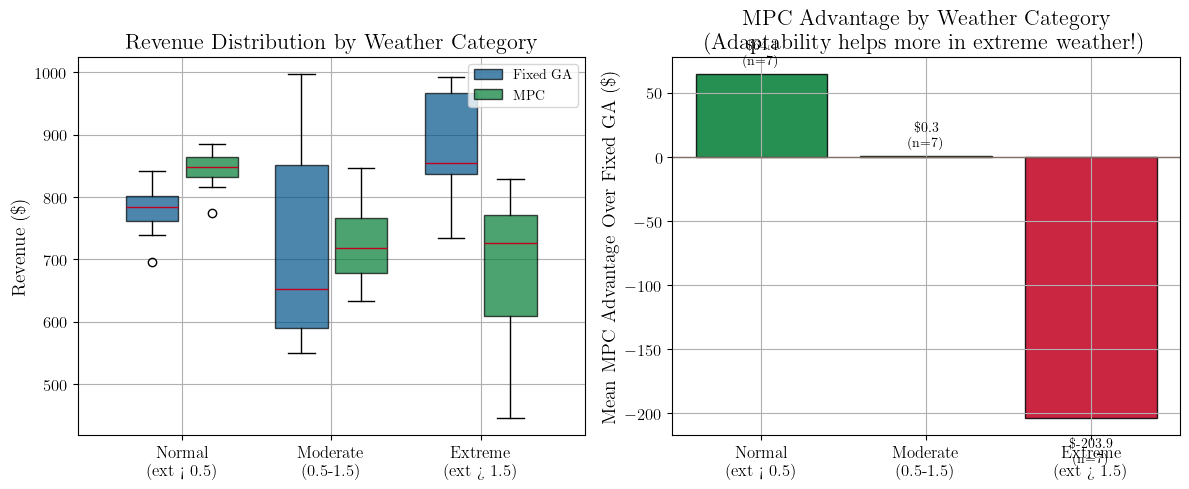

In [11]:
# Categorize scenarios
normal = valid[valid['extremity'] < 0.5]
moderate = valid[(valid['extremity'] >= 0.5) & (valid['extremity'] < 1.5)]
extreme = valid[valid['extremity'] >= 1.5]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

categories = ['Normal\n(ext < 0.5)', 'Moderate\n(0.5-1.5)', 'Extreme\n(ext > 1.5)']

# Left: Box plot comparison by weather category
ga_data = [normal['fixed_ga_revenue'].values, moderate['fixed_ga_revenue'].values, extreme['fixed_ga_revenue'].values]
mpc_data = [normal['mpc_revenue'].values, moderate['mpc_revenue'].values, extreme['mpc_revenue'].values]

ax1 = axes[0]
positions_ga = np.array([1, 2, 3]) - 0.2
positions_mpc = np.array([1, 2, 3]) + 0.2

bp_ga = ax1.boxplot(ga_data, positions=positions_ga, widths=0.35, patch_artist=True)
bp_mpc = ax1.boxplot(mpc_data, positions=positions_mpc, widths=0.35, patch_artist=True)

for patch in bp_ga['boxes']:
    patch.set_facecolor(plotting_colors.strong_blue)
    patch.set_alpha(0.7)
for patch in bp_mpc['boxes']:
    patch.set_facecolor(plotting_colors.vivid_green)
    patch.set_alpha(0.7)

ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(categories)
ax1.set_ylabel('Revenue (\\$)')
ax1.set_title('Revenue Distribution by Weather Category')
ax1.legend([bp_ga['boxes'][0], bp_mpc['boxes'][0]], ['Fixed GA', 'MPC'], loc='upper right')

# Right: MPC advantage by category
ax2 = axes[1]
category_advantages = [
    normal['mpc_advantage'].mean() if len(normal) > 0 else 0,
    moderate['mpc_advantage'].mean() if len(moderate) > 0 else 0,
    extreme['mpc_advantage'].mean() if len(extreme) > 0 else 0
]
category_counts = [len(normal), len(moderate), len(extreme)]

bar_colors = [plotting_colors.vivid_red if x < 0 else plotting_colors.vivid_green for x in category_advantages]
bars = ax2.bar(categories, category_advantages, color=bar_colors, alpha=0.85, 
               edgecolor='black', linewidth=1)
ax2.axhline(0, color=plotting_colors.medium_gray, linestyle='-', linewidth=1)
ax2.set_ylabel('Mean MPC Advantage Over Fixed GA (\\$)')
ax2.set_title('MPC Advantage by Weather Category\n(Adaptability helps more in extreme weather!)')

# Add value labels
for bar, val, count in zip(bars, category_advantages, category_counts):
    ypos = val + 5 if val >= 0 else val - 15
    ax2.text(bar.get_x() + bar.get_width()/2, ypos, f'\${val:.1f}\n(n={count})', 
             ha='center', va='bottom' if val >= 0 else 'top', fontsize=10)

plt.tight_layout()
plt.savefig('weather_scenario_results/fixed_ga_vs_mpc_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Visualization 5: Worst-Case Analysis

Examine the most extreme scenario to see how MPC adapts where the fixed strategy struggles.

Worst scenario for Fixed GA: cool_wet
  Fixed GA revenue:  $549.83
  MPC revenue:       $640.77
  MPC advantage:     $90.94 (16.5%)
  Extremity:         1.10


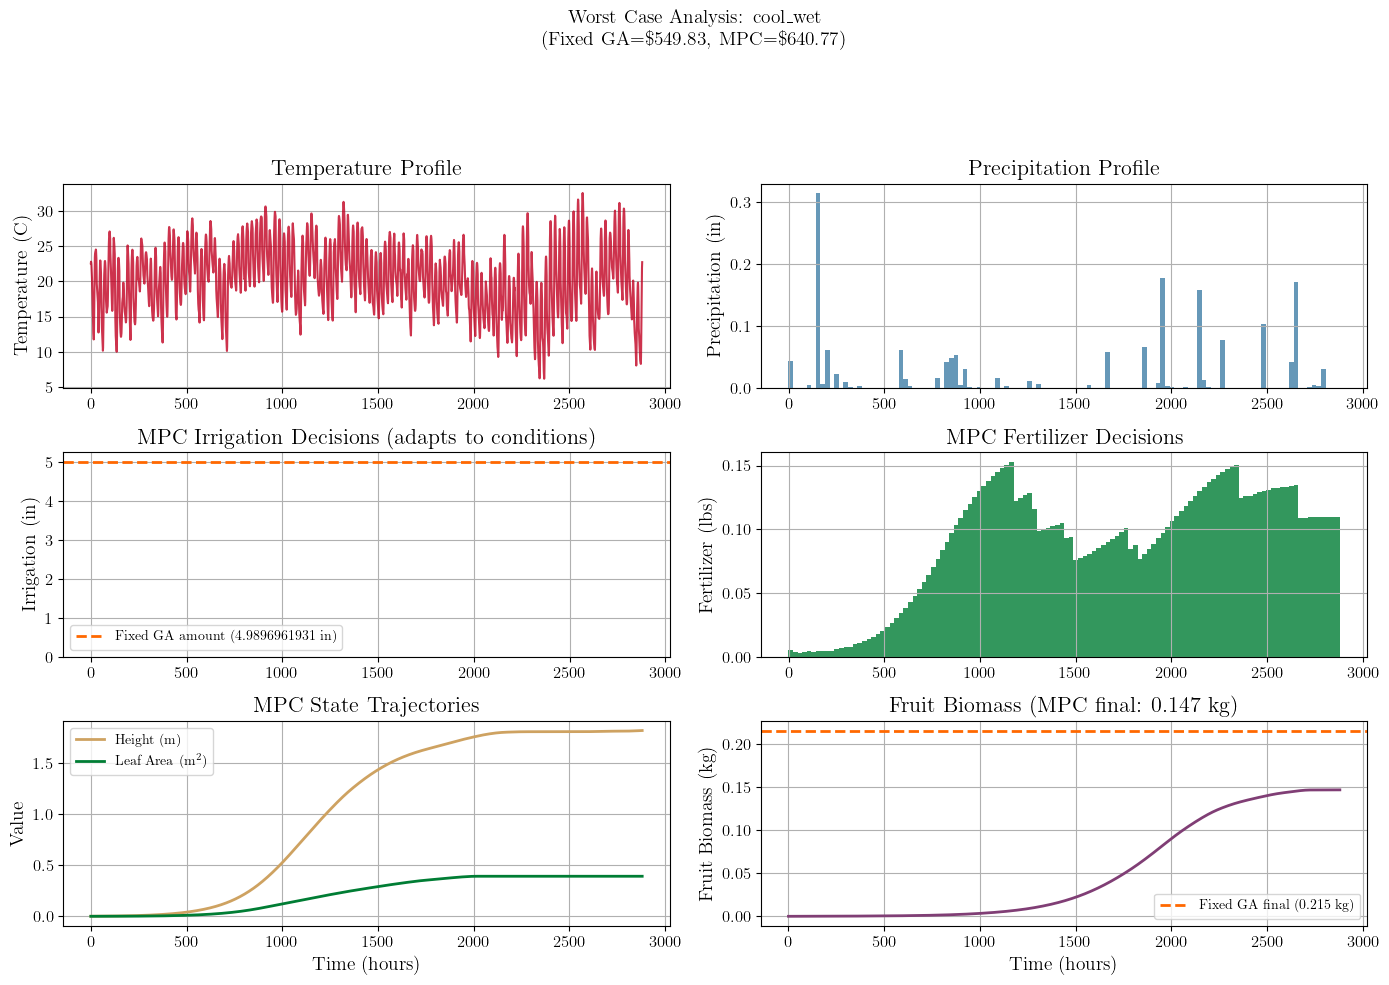

In [12]:
# Find worst and best scenarios for fixed GA
worst_idx = valid['fixed_ga_revenue'].idxmin()
worst_scenario = valid.loc[worst_idx, 'scenario']

print(f"Worst scenario for Fixed GA: {worst_scenario}")
print(f"  Fixed GA revenue:  ${valid.loc[worst_idx, 'fixed_ga_revenue']:.2f}")
print(f"  MPC revenue:       ${valid.loc[worst_idx, 'mpc_revenue']:.2f}")
print(f"  MPC advantage:     ${valid.loc[worst_idx, 'mpc_advantage']:.2f} ({valid.loc[worst_idx, 'mpc_advantage_pct']:.1f}%)")
print(f"  Extremity:         {valid.loc[worst_idx, 'extremity']:.2f}")

# Plot MPC trajectory for worst scenario if available
if worst_scenario in mpc_trajectories:
    traj = mpc_trajectories[worst_scenario]
    weather = weather_data[worst_scenario]
    
    fig, axes = plt.subplots(3, 2, figsize=(14, 10))
    fig.suptitle(f'Worst Case Analysis: {worst_scenario}\n(Fixed GA=\${valid.loc[worst_idx, "fixed_ga_revenue"]:.2f}, MPC=\${valid.loc[worst_idx, "mpc_revenue"]:.2f})', fontsize=14)
    
    hours = np.arange(len(traj['h']))
    
    # Weather: Temperature
    ax = axes[0, 0]
    ax.plot(weather['Temperature (C)'].values[:len(hours)], 
            color=plotting_colors.vivid_red, alpha=0.8)
    ax.set_ylabel('Temperature (C)')
    ax.set_title('Temperature Profile')
    
    # Weather: Precipitation
    ax = axes[0, 1]
    ax.bar(range(len(hours)), weather['Hourly Precipitation (in)'].values[:len(hours)], 
           color=plotting_colors.strong_blue, alpha=0.6, width=1)
    ax.set_ylabel('Precipitation (in)')
    ax.set_title('Precipitation Profile')
    
    # MPC: Irrigation decisions
    ax = axes[1, 0]
    ax.bar(range(len(traj['irrigation'])), traj['irrigation'], 
           color=plotting_colors.strong_blue, alpha=0.8, width=1)
    ax.axhline(FIXED_IRRIGATION_AMOUNT, color=plotting_colors.vivid_orange, 
               linestyle='--', linewidth=2, label=f'Fixed GA amount ({FIXED_IRRIGATION_AMOUNT} in)')
    ax.set_ylabel('Irrigation (in)')
    ax.set_title('MPC Irrigation Decisions (adapts to conditions)')
    ax.legend()
    
    # MPC: Fertilizer decisions  
    ax = axes[1, 1]
    ax.bar(range(len(traj['fertilizer'])), traj['fertilizer'], 
           color=plotting_colors.vivid_green, alpha=0.8, width=1)
    ax.set_ylabel('Fertilizer (lbs)')
    ax.set_title('MPC Fertilizer Decisions')
    
    # State trajectories: Height and Leaf Area
    ax = axes[2, 0]
    ax.plot(hours, traj['h'], label='Height (m)', color=plotting_colors.grayish_yellow, linewidth=2)
    ax.plot(hours, traj['A'], label='Leaf Area (m$^2$)', color=plotting_colors.vivid_green, linewidth=2)
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Value')
    ax.set_title('MPC State Trajectories')
    ax.legend()
    
    # State trajectory: Fruit biomass
    ax = axes[2, 1]
    ax.plot(hours, traj['P'], color=plotting_colors.strong_purple, linewidth=2)
    ax.axhline(valid.loc[worst_idx, 'ga_fruit'], color=plotting_colors.vivid_orange,
               linestyle='--', linewidth=2, label=f'Fixed GA final ({valid.loc[worst_idx, "ga_fruit"]:.3f} kg)')
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Fruit Biomass (kg)')
    ax.set_title(f'Fruit Biomass (MPC final: {traj["P"][-1]:.3f} kg)')
    ax.legend()
    
    plt.tight_layout(rect=plotting_params.tight_layout_rect)
    plt.savefig('weather_scenario_results/fixed_ga_vs_mpc_worst_case.png', dpi=150, bbox_inches='tight')
    plt.show()

## 11. Key Findings

In [17]:
print("\n" + "=" * 70)
print("KEY FINDINGS: Fixed GA Baseline vs Adaptive MPC")
print("=" * 70)

# Calculate key metrics
mpc_wins = (valid['mpc_advantage'] > 0).sum()
total = len(valid)
mean_advantage = valid['mpc_advantage'].mean()

# By category
normal_advantage = normal['mpc_advantage'].mean() if len(normal) > 0 else 0
moderate_advantage = moderate['mpc_advantage'].mean() if len(moderate) > 0 else 0
extreme_advantage = extreme['mpc_advantage'].mean() if len(extreme) > 0 else 0

print(f"\n1. OVERALL PERFORMANCE")
print(f"   - MPC outperforms Fixed GA in {mpc_wins}/{total} scenarios ({mpc_wins/total*100:.1f}%)")
print(f"   - Average MPC advantage: ${mean_advantage:.2f}")

print(f"\n2. ADAPTABILITY VALUE BY WEATHER CATEGORY")
print(f"   - Normal weather (ext < 0.5):    MPC advantage = ${normal_advantage:.2f}")
print(f"   - Moderate weather (0.5-1.5):    MPC advantage = ${moderate_advantage:.2f}")
print(f"   - Extreme weather (ext > 1.5):   MPC advantage = ${extreme_advantage:.2f}")
print(f"   - Correlation (extremity vs advantage): R = {r_value:.3f}")

print(f"\n3. RISK MANAGEMENT")
ga_min = valid['fixed_ga_revenue'].min()
mpc_min = valid['mpc_revenue'].min()
ga_std = valid['fixed_ga_revenue'].std()
mpc_std = valid['mpc_revenue'].std()
print(f"   - Fixed GA worst case:  ${ga_min:.2f}")
print(f"   - MPC worst case:       ${mpc_min:.2f}")
print(f"   - MPC reduces worst-case loss by: ${mpc_min - ga_min:.2f}")
print(f"   - Fixed GA revenue std: ${ga_std:.2f}")
print(f"   - MPC revenue std:      ${mpc_std:.2f}")

print(f"\n4. RESOURCE EFFICIENCY")
print(f"   - Fixed GA uses SAME resources for all scenarios:")
print(f"       Irrigation: {valid['ga_irrigation'].iloc[0]:.1f} in, Fertilizer: {valid['ga_fertilizer'].iloc[0]:.1f} lbs")
print(f"   - MPC adapts resources to each scenario:")
print(f"       Irrigation: {valid['mpc_irrigation'].min():.1f}-{valid['mpc_irrigation'].max():.1f} in")
print(f"       Fertilizer: {valid['mpc_fertilizer'].min():.1f}-{valid['mpc_fertilizer'].max():.1f} lbs")


KEY FINDINGS: Fixed GA Baseline vs Adaptive MPC

1. OVERALL PERFORMANCE
   - MPC outperforms Fixed GA in 12/21 scenarios (57.1%)
   - Average MPC advantage: $-46.37

2. ADAPTABILITY VALUE BY WEATHER CATEGORY
   - Normal weather (ext < 0.5):    MPC advantage = $64.44
   - Moderate weather (0.5-1.5):    MPC advantage = $0.31
   - Extreme weather (ext > 1.5):   MPC advantage = $-203.87
   - Correlation (extremity vs advantage): R = -0.656

3. RISK MANAGEMENT
   - Fixed GA worst case:  $549.83
   - MPC worst case:       $444.93
   - MPC reduces worst-case loss by: $-104.90
   - Fixed GA revenue std: $132.08
   - MPC revenue std:      $115.35

4. RESOURCE EFFICIENCY
   - Fixed GA uses SAME resources for all scenarios:
       Irrigation: 15.0 in, Fertilizer: 307.1 lbs
   - MPC adapts resources to each scenario:
       Irrigation: 1.3-2.0 in
       Fertilizer: 215.6-307.1 lbs


In [14]:
# Save comparison results
comparison_df.to_csv('weather_scenario_results/fixed_ga_vs_mpc_comparison.csv', index=False)

with open('weather_scenario_results/fixed_ga_vs_mpc_summary.pkl', 'wb') as f:
    pickle.dump({
        'comparison_df': comparison_df,
        'fixed_ga_results': fixed_ga_results,
        'fixed_strategy': {
            'irrigation_frequency': FIXED_IRRIGATION_FREQUENCY,
            'irrigation_amount': FIXED_IRRIGATION_AMOUNT,
            'fertilizer_frequency': FIXED_FERTILIZER_FREQUENCY,
            'fertilizer_amount': FIXED_FERTILIZER_AMOUNT
        },
        'mpc_wins': mpc_wins,
        'total_scenarios': total,
        'mean_advantage': mean_advantage,
        'correlation_r': r_value,
        'correlation_p': p_value,
        'trend_slope': slope
    }, f)

print("\nResults saved to weather_scenario_results/:")
print("  - fixed_ga_vs_mpc_comparison.csv")
print("  - fixed_ga_vs_mpc_summary.pkl")
print("  - fixed_ga_vs_mpc_*.png (visualizations)")


Results saved to weather_scenario_results/:
  - fixed_ga_vs_mpc_comparison.csv
  - fixed_ga_vs_mpc_summary.pkl
  - fixed_ga_vs_mpc_*.png (visualizations)
